In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor

c:\Users\TonVo\anaconda3\envs\myenv3.10\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
import os

from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [3]:
TRAIN_START_DATE = '2008-01-01'
TRAIN_END_DATE = '2019-01-01'
TRADE_START_DATE = '2019-01-01'
TRADE_END_DATE = '2021-10-01'

In [4]:
df = YahooDownloader(start_date = '2008-01-01',
                     end_date = '2023-10-01',
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [5]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2008-01-02,7.116786,7.152143,6.876786,5.898640,1079178800,AAPL,2
1,2008-01-02,46.599998,47.040001,46.259998,33.761410,7934400,AMGN,2
2,2008-01-02,52.090000,52.320000,50.790001,39.460514,8053700,AXP,2
3,2008-01-02,87.570000,87.839996,86.000000,63.481594,4303000,BA,2
4,2008-01-02,72.559998,72.669998,70.050003,45.605465,6337800,CAT,2


In [6]:
fe = FeatureEngineer(use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_turbulence=False,
                    use_vix=True,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (3963, 8)
Successfully added vix


In [7]:
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)


df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [8]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,2.583909,607541200,AAPL,2,-0.082603,3.093652,2.454291,42.254760,-80.462628,16.129793,2.749560,2.861671,40.0,"[[0.0013489695508097023, 0.0004284123121230200...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,41.839504,6287200,AMGN,2,0.156757,42.707030,40.853196,51.060581,51.523032,10.432018,41.058035,40.603777,40.0,"[[0.0013489695508097023, 0.0004284123121230200...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,14.533794,9625600,AXP,2,-0.932570,18.586825,12.619704,42.554829,-75.445696,25.776759,15.693366,17.559646,40.0,"[[0.0013489695508097023, 0.0004284123121230200...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,32.005886,5443100,BA,2,-0.279800,32.174386,28.867832,47.440232,156.994661,5.366299,30.327213,32.389914,40.0,"[[0.0013489695508097023, 0.0004284123121230200...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,29.608650,6277400,CAT,2,0.655611,30.348091,25.455650,51.205297,98.374075,26.331746,26.689552,26.423593,40.0,"[[0.0013489695508097023, 0.0004284123121230200...",tic AAPL AMGN AXP ...


In [9]:
train = data_split(df, start=TRAIN_START_DATE, end=TRAIN_END_DATE)
trade = data_split(df, start=TRADE_START_DATE, end=TRADE_END_DATE)

In [10]:
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv

In [11]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 28, State Space: 28


The state that the model observes is a matrix $\in$ $\mathbb{R}^{28 \times 36}$, which incorporates the covariance matrix and the technical indicators. Before the matrix is passed to the MLP, it gets flattened so that it can be used.

In [12]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

The `StockPortfolioEnv` class is initialized with the following parameters:

- $H_{\text{max}}$: Maximum number of shares to buy or sell, set to 100 in this case.
- $M_{\text{initial}}$: Initial amount of money in the portfolio, set to 1,000,000 in this case.
- $C_{\text{transaction}}$: Transaction cost percentage per trade, set to 0.001 in this case.
- $S$: State space of the environment, represented by the variable `state_space`.
- $n$: Number of unique stocks, represented by the variable `stock_dim`.
- $I$: List of technical indicators, represented by `config.INDICATORS`.
- $A$: Action space of the environment, which is equal to the number of unique stocks ($n$). For each stock, an action can be to buy, sell, or hold.
- $r_{\text{scaling}}$: Scaling factor for the reward, set to $1 \times 10^{-4}$ in this case.

In [13]:
env_train, _ = e_train_gym.get_sb_env()

In [14]:
agent = DRLAgent(env = env_train)
DDG_PARAMS = {"batch_size": 128,
              "buffer_size": 50000,
              "learning_rate": 0.001}

model_ddpg = agent.get_model("ddpg", model_kwargs = DDG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


Below is some pseudocode for the DDPG algorithm from [OpenAI](https://spinningup.openai.com/en/latest/algorithms/ddpg.html). The original paper can be found [here](https://arxiv.org/abs/1509.02971).

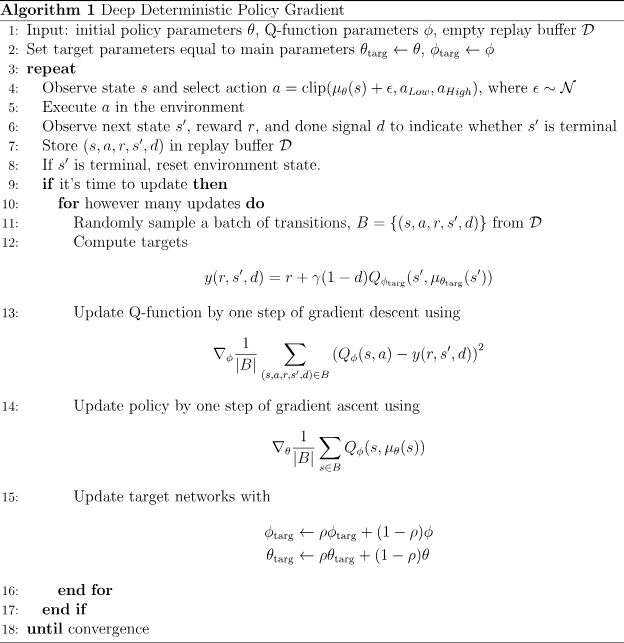

The main intuition is that the actor network is used to approximate the optimal policy $\mu(s)$, while the critic network is used to approximate the action-value function $Q(s, a)$. The actor network is trained by using the gradient of the critic network with respect to the action. The critic network is trained by using the Bellman equation as the target value. Target networks are used to stabilize the training process. We also introduce some noise to the action to encourage exploration.

In [15]:
trained_ddpg = agent.train_model(model=model_ddpg,
                                 tb_log_name='ddpg',
                                 total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:4870872.498507117
Sharpe:  1.0749945928424933
begin_total_asset:1000000
end_total_asset:5188821.330432643
Sharpe:  1.1116141299137292
begin_total_asset:1000000
end_total_asset:5188821.330432643
Sharpe:  1.1116141299137292
begin_total_asset:1000000
end_total_asset:5188821.330432643
Sharpe:  1.1116141299137292
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 77        |
|    time_elapsed    | 129       |
|    total_timesteps | 10068     |
| train/             |           |
|    actor_loss      | -7.35e+07 |
|    critic_loss     | 5.9e+12   |
|    learning_rate   | 0.001     |
|    n_updates       | 7551      |
|    reward          | 5188821.5 |
----------------------------------
begin_total_asset:1000000
end_total_asset:5188821.330432643
Sharpe:  1.1116141299137292
begin_total_asset:1000000
end_total_asset:5188821.330432643
Sharpe:  1.1116141299137292
begin_total_asset

In [23]:
trained_ddpg.actor

Actor(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mu): Sequential(
    (0): Linear(in_features=1008, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=28, bias=True)
    (5): Tanh()
  )
)

The `Actor` class in the code above represents the policy model:

1. **Features Extractor**: The `FlattenExtractor` is used to flatten the input tensor. If $X$ is the input tensor, the operation can be represented as:

    $$X_{\text{flat}} = \text{Flatten}(X)$$

2. **Sequential Model (`mu`)**: This is a feed-forward neural network (FNN) that maps the flattened input to the action space. The FNN consists of three fully connected (`Linear`) layers with ReLU activation functions, followed by a `Tanh` activation function. If $W_i$ and $b_i$ represent the weights and biases of the $i$-th layer, and $h_i$ represents the output after the $i$-th layer, the operations can be represented as:

    $$h_0 = X_{\text{flat}}$$
    $$h_1 = \text{ReLU}(W_1 h_0 + b_1)$$
    $$h_2 = \text{ReLU}(W_2 h_1 + b_2)$$
    $$h_3 = \text{Tanh}(W_3 h_2 + b_3)$$

Here, $h_3$ represents the output of the `Actor` model, which is the action taken by the agent.

3. **Softmax Layer**: The output of the `Actor` model, $h_3$, then goes through a softmax function to produce the weights over the action space. The softmax function is defined as:

    $$\text{Softmax}(x_i) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

Applying this to $h_3$, we get:

$$p_i = \frac{\exp(h_{3,i})}{\sum_j \exp(h_{3,j})}$$

Here, $p$ represents the probability distribution over the action space, which can be interpreted as the weights for each stock.


In [36]:
trained_ddpg.critic

ContinuousCritic(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (qf0): Sequential(
    (0): Linear(in_features=1036, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=1, bias=True)
  )
)

The critic architecture is very similar to the actor architecture:

1. **Features Extractor**: The `FlattenExtractor` is used to flatten the input tensor. If $X$ is the input tensor, the operation can be represented as:

    $$X_{\text{flat}} = \text{Flatten}(X)$$

2. **Sequential Model (`qf0`)**: This is a feed-forward neural network (FNN) that maps the flattened input to a single output value. The FNN consists of three fully connected (`Linear`) layers with ReLU activation functions. If $W_i$ and $b_i$ represent the weights and biases of the $i$-th layer, and $h_i$ represents the output after the $i$-th layer, the operations can be represented as:

    $$h_0 = X_{\text{flat}}$$
    $$h_1 = \text{ReLU}(W_1 h_0 + b_1)$$
    $$h_2 = \text{ReLU}(W_2 h_1 + b_2)$$
    $$h_3 = W_3 h_2 + b_3$$

Here, $h_3$ represents the output of the `ContinuousCritic` model, which is the estimated value of the given state-action pair.

In [16]:
e_trade_gym = StockPortfolioEnv(df = trade, turbulence_threshold=250, **env_kwargs)

In [24]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ddpg, environment=e_trade_gym)

begin_total_asset:1000000
end_total_asset:1703733.9288533884
Sharpe:  0.9371133966849969
hit end!


In [26]:
from pyfolio import timeseries
DLR_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats
perf_stats_all = perf_func(returns=DLR_strat,
                       factor_returns=DLR_strat,
                        positions=None,
                        transactions=None,
                        turnover_denom="AGB")

In [27]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.213797
Cumulative returns      0.703734
Annual volatility       0.236938
Sharpe ratio            0.937113
Calmar ratio            0.634928
Stability               0.833425
Max drawdown           -0.336727
Omega ratio             1.227377
Sortino ratio           1.318788
Skew                   -0.484015
Kurtosis               19.544321
Tail ratio              0.922778
Daily value at risk    -0.028970
Alpha                   0.000000
Beta                    1.000000
dtype: float64

In [28]:
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (692, 8)
Annual return          0.151492
Cumulative returns     0.473073
Annual volatility      0.242630
Sharpe ratio           0.704554
Calmar ratio           0.408486
Stability              0.600261
Max drawdown          -0.370862
Omega ratio            1.167494
Sortino ratio          0.973706
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.907059
Daily value at risk   -0.029890
dtype: float64
